# Literature model

In this notebook a base model for 2-stage processes is implemented. This model is created for aerob/anaerob fermentation and is not yet adapted for the pDNA production process.

In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import pandas as pd

plt.rc('font', size=14)

import os
dir = 'plots/00literature_model'
if not os.path.exists(dir):
    os.makedirs(dir)

In [2]:
# Parameters for the 1 stage process

Y_X_S = 0.022  # (True) biomass yield from substrate
Y_P_X =  69.3 # (True) product yield per biomass produced (under growth-coupling)
Y_P_ATP = 1  # (True) product yield per mole ATP produced
Y_ATP_S = 2  # (True) ATP yield per substrate
r_S_max = 13.3  # Maximal substrate uptake rate
m_ATP = 7.7  # Demand of ATP for non-growth associated maintenance (NGAM)

# Parameters for the 2 stage process

Y_X_S_growth = 0.098  # (True) biomass yield from substrate
Y_P_X_growth =  0  # (True) product yield per biomass produced (under growth-coupling)
Y_P_ATP_growth = 0  # (True) product yield per mole ATP produced
Y_ATP_S_growth = 23.5  # (True) ATP yield per substrate
r_S_max_growth = 10  # Maximal substrate uptake rate
m_ATP_growth = 7.7  # Demand of ATP for non-growth associated maintenance (NGAM)

Y_P_ATP_production = 1  # (True) product yield per mole ATP produced
Y_ATP_S_production = 2  # (True) ATP yield per substrate
m_ATP_production = 7.7  # Demand of ATP for non-growth associated maintenance (NGAM)

In [3]:
# odes for different phases

def OSF(t, y):
    """returns derivate for the 1 stage process
    y is vector of X, S and P"""
    X = y[0]  # biomass
    S = y[1]  # substrate
    P = y[2]  # product

    mu = Y_X_S * (r_S_max - m_ATP / Y_ATP_S)
    r_S = r_S_max
    r_P = mu * Y_P_X + m_ATP * Y_P_ATP
    q_S = r_S * X
    q_P = r_P * X
    if S > 0:
        return (mu * X, -q_S, q_P)
    else:
        return (0, 0, 0)


def TSF_growth(t, y):
    """calculates the derivate for the growth stage of 2 step process"""
    X = y[0]  # biomass
    S = y[1]  # substrate
    P = y[2]  # product
    mu = Y_X_S_growth * (r_S_max_growth - m_ATP_growth / Y_ATP_S_growth)
    r_S = r_S_max_growth
    r_P = mu * Y_P_X_growth + m_ATP_growth * Y_P_ATP_growth
    q_S = r_S * X
    q_P = r_P * X
    return (mu * X, -q_S, q_P)


def TSF_production(t, y):
    """calculates the derivate for the production stage of 2 step process"""
    X = y[0]  # biomass
    S = y[1]  # substrate
    P = y[2]  # product

    mu = 0
    r_S = m_ATP_production / Y_ATP_S_production
    r_P = m_ATP_production * Y_P_ATP_production
    q_S = r_S * X
    q_P = r_P * X
    return (mu * X, -q_S, q_P)

def TSF(t, y):
    """calculates the derivate 2 step process"""
    S = y[1]
    if S > S_switch:
        return TSF_growth(t, y)
    elif S > 0:
        return TSF_production(t , y)
    else:
        return (0, 0, 0)

In [4]:
# starting values

X0 = 0.01
S0 = 10
P0 = 0
y0 = np.array((X0, S0, P0))
t_end = 20

# calculate switch point for 2 stage process

mu = Y_X_S * (r_S_max - m_ATP / Y_ATP_S)
Y_obs_P_S = (mu * Y_P_X + m_ATP * Y_P_ATP) / r_S_max
P_target = S0 * Y_obs_P_S
S_switch = (P_target) / (Y_ATP_S_production * Y_P_ATP_production)


# 1 stage process

res = scipy.integrate.solve_ivp(fun=OSF, t_span=(0, t_end), y0 = y0, t_eval= np.linspace(0, t_end, 100))
OSF_results = pd.DataFrame(res.y.T, columns=('X', 'S', 'P'), index=res.t)
OSF_results['mu'] = mu * (OSF_results.S > 0)


# 2 stage process

res = scipy.integrate.solve_ivp(fun=TSF, t_span=(0, t_end), y0 = y0, t_eval= np.linspace(0, t_end, 100))
TSF_results = pd.DataFrame(res.y.T, columns=('X', 'S', 'P'), index=res.t)

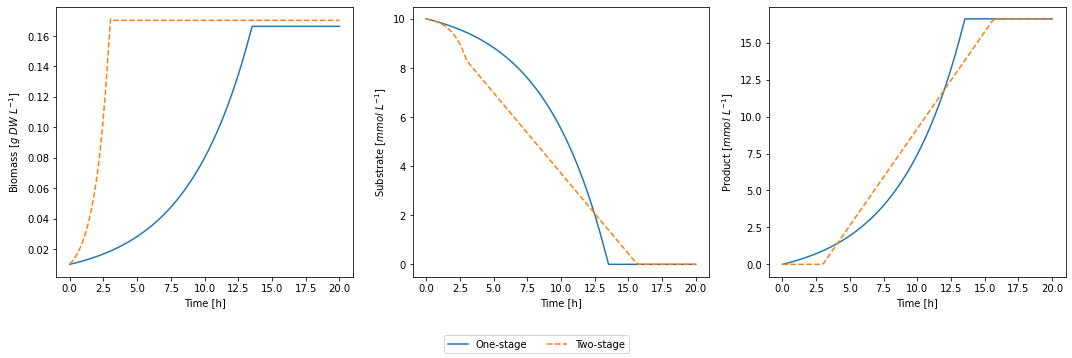

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(OSF_results.X, '-', label='One-stage')
axs[0].plot(TSF_results.X, '--', label='Two-stage')
axs[0].set_ylabel('Biomass $[g \\ DW \\ L^{-1}]$')
# axs[0].legend()
axs[0].set_xlabel('Time [h]')

axs[1].plot(OSF_results.S, '-')
axs[1].plot(TSF_results.S, '--')
axs[1].set_ylabel('Substrate $[ mmol \\ L^{-1} ]$')
#axs[1].legend()
axs[1].set_xlabel('Time [h]')

axs[2].plot(OSF_results.P, '-')
axs[2].plot(TSF_results.P, '--')
axs[2].set_ylabel('Product $[mmol \\ L^{-1} ]$')
#axs[2].legend()
axs[2].set_xlabel('Time [h]')

# axs[3].plot(OSF_results.mu, label='One-stage')

fig.tight_layout()

fig.subplots_adjust(bottom=0.22)
fig.legend(loc="lower center", ncol=2)

plt.savefig('plots/00literature_model/model.png', facecolor="white", bbox_inches="tight")
plt.show()

In [6]:
def end_process(t, y):
    return y[1]

end_process.terminate = True

def get_productivity(S_switch):
    
    def TSF(t, y):
        S = y[1]
        if S > S_switch:
            return TSF_growth(t, y)
        elif S > 0:
            return TSF_production(t , y)
        else:
            return (0, 0, 0)
    
    t_end = 50
    res = scipy.integrate.solve_ivp(fun=TSF, t_span=(0, t_end), y0 = y0, events=end_process)
    t_two_stage = res.t_events[0][0]
    product_two_stage = res.y_events[0][0][2]
    volumetric_productivity_two_stage = product_two_stage / t_two_stage
    product_yield = product_two_stage / S0
    return (product_yield, volumetric_productivity_two_stage)


In [7]:
get_productivity(3)

(0.6002014394158925, 1.0720237014756404)

In [8]:
results = list()
for S_switch in np.linspace(3, 9.5, 20):
    results.append(get_productivity(S_switch))
    
productivity = pd.DataFrame(results, columns=('yield', 'productivity'))
productivity.set_index('yield', inplace=True)

In [9]:
OSF_yield = np.array(OSF_results.P) / S0
OSF_productivity = np.array(OSF_results.P) / OSF_results.index

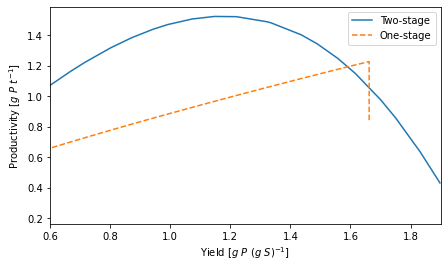

In [10]:
fig, ax = plt.subplots(1, 1, figsize=[7, 4])
ax.plot(productivity, '-', label='Two-stage')
ax.plot(OSF_yield, OSF_productivity, '--', label='One-stage')
ax.set_xlim([0.6, 1.9])
ax.set_xlabel('Yield $[g \\ P \\ (g \\ S)^{-1}]$')
ax.set_ylabel('Productivity $[g \\ P \\ t^{-1}]$')
ax.legend()
plt.savefig('plots/00literature_model/compare.png', facecolor="white", bbox_inches="tight")
plt.show()

In [11]:
# maximum volumetric productivity

productivity.idxmax()

productivity    1.147673
dtype: float64

In [12]:
productivity.max()

productivity    1.524673
dtype: float64